In [46]:
!pip install --upgrade azureml-sdk

Requirement already up-to-date: azureml-sdk in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.36.0)


In [64]:
import azureml.core

print("read to use Azure Ml", azureml.core.VERSION)

read to use Azure Ml 1.34.0


In [65]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, "loaded")

basicmachinelearning001 loaded


In [66]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Compute Targets:")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':',compute.type)

Compute Targets:
	 aml-inference : AKS
	 aml-instance001 : ComputeInstance
	 aml-cluster001 : AmlCompute


In [67]:
print("Datastores:")
for datastore_name in ws.datastores:
    datastore = Datastore.get(ws, datastore_name)
    print("\t", datastore.name, ':',datastore.datastore_type)

Datastores:
	 azureml_globaldatasets : AzureBlob
	 workspaceworkingdirectory : AzureFile
	 workspacefilestore : AzureFile
	 workspaceartifactstore : AzureBlob
	 workspaceblobstore : AzureBlob


In [68]:
print("Datasets:")
for dataset_name in (ws.datasets.keys()):
    dataset = Dataset.get(ws, dataset_name)
    print("\t", dataset.name)

Datasets:
	 TD-Visual_Diabetes_Training-Normalize_Data-Transformation_function-40916bc0
	 MD-Visual_Diabetes_Training-Train_Model-Trained_model-580708a2
	 diabetes dataset


In [73]:
endpoint = '[Endpoint]' #Replace with your endpoint
key = '[Key]' #Replace with your key

import urllib.request
import json
import os

data = {
    "Inputs": {
        "WebServiceInput0":
        [
            {
                'PatientID': "1354778",
                'Pregnancies': "0",
                'PlasmaGlucose': "171",
                'DiastolicBloodPressure': "80",
                'TricepsThickness': "34",
                'SerumInsulin': "23",
                'BMI': "43.50972593",
                'DiabetesPedigree': "1.213191354",
                'Age': "21",
                'Diabetic': "0",
            },
        ],
    },
    "GlobalParameters": {
    }
}

body = str.encode(json.dumps(data))


headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ key)}

req = urllib.request.Request(endpoint, body, headers)

try:
    response = urllib.request.urlopen(req)
    result = response.read()
    json_result = json.loads(result)
    output = json_result["Results"]["WebServiceOutput0"][0]
    print('Patient: {}\nPrediction: {}\nProbability: {:.2f}'.format(output["PatientID"],
                                                            output["Scored Labels"],
                                                            output["Scored Probabilities"],))
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers to help debug
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))

Patient: 1354778.0
Prediction: 0.0
Probability: 0.35


In [74]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
# Create Experiment

experiment = Experiment(workspace=ws, name="diabetes-experiments")

In [76]:
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

Starting experiment: diabetes-experiments


In [77]:
# Load Data

data = pd.read_csv('data/diabetes.csv')
data

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
9995,1469198,6,95,85,37,267,18.497542,0.660240,31,0
9996,1432736,0,55,51,7,50,21.865341,0.086589,34,0
9997,1410962,5,99,59,47,67,30.774018,2.301594,43,1
9998,1958653,0,145,67,30,21,18.811861,0.789572,26,0


In [78]:
row_count = (len(data))
run.log('observation', row_count)
print("Analyzing {} rows of data".format(row_count))

Analyzing 10000 rows of data


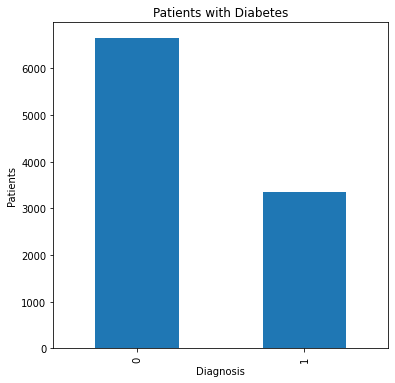

In [79]:
diabetic_counts = data['Diabetic'].value_counts()

fig = plt.figure(figsize=(6,6))
ax = fig.gca()

diabetic_counts.plot.bar(ax = ax)
ax.set_title('Patients with Diabetes')
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Patients')
plt.show()

run.log_image(name='label distribution', plot=fig)

In [80]:
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

In [81]:
run.complete()

In [82]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…